# TEXT DOCUMENT CLUSTERING WITH TF-IDF, KMEANS, AND FP-GROWTH

In [6]:
import re
import nltk
import json
import numpy as np
import pandas as pd
from html import unescape

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

from kneed import KneeLocator

## PREPROCESSING FUNCTIONS

In [7]:
def tokenize_and_stem(text):
    tokens = re.findall("[A-Z]{2,}(?![a-z])|[A-Z][a-z]+(?=[A-Z])|[\'\w\-]+",text)
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token.lower())
    return ' '.join(filtered_tokens)

def punc(docs):
    toreturn = []
    for word in re.findall(r"[\w\-_#]+", docs):
        if word not in stopwords.words('english') and not word.isnumeric():
            toreturn.append(word)
    return ' '.join(toreturn)

## LOADING DATASET

In [8]:
with open('movie_dataset.json') as f:
    linklist = json.load(f)
df = pd.DataFrame(linklist['results'])
df

,t,a,c,d
0,Movie Coverage - YouTube,https://www.youtube.com/channel/UCwYzZs_hwA6Nd...,www.youtube.com › channel,The best of films and movie trailers. Pick you...
1,Marvel Studios Celebrates The Movies - YouTube,https://www.youtube.com/watch%3Fv%3DQdpxoFcdORI,www.youtube.com › watch,Duration: 3:11 Posted: 3 days ago ...
2,FRESH Movie Trailers - YouTube,https://www.youtube.com/c/FreshMovieTrailers,www.youtube.com › FreshMovieTrailers,All NEW MOVIE TRAILERS are Here! Don't miss th...
3,Movie: The Movie - YouTube,https://www.youtube.com/watch%3Fv%3Dw3NwB9PLxss,www.youtube.com › watch,Duration: 8:33 Posted: 26-Feb-2012 ...
4,"Tippu Hindi Dubbed Full Movie | Satya Karthik,...",https://www.youtube.com/watch%3Fv%3DVf3KQa5jh4M,www.youtube.com › watch,Duration: 1:31:46 Posted: 1 day ago...
5,Jaanu 2021 New Released Hindi Dubbed Movie | S...,https://www.youtube.com/watch%3Fv%3DDbSpMI17xiQ,www.youtube.com › watch,Duration: 2:07:11 Posted: 18-Apr-20...
6,Film - Wikipedia,https://en.wikipedia.org/wiki/Film,en.wikipedia.org › wiki › Film,"A film, also called a movie, motion picture or..."
7,Watch Movies Online | Watch Originals Shows On...,https://www.aha.video/,www.aha.video,Watch unlimited exclusive movies and originals...
8,Movies | Netflix Official Site,https://www.netflix.com/browse/genre/34399,www.netflix.com › browse › genre,"Movies move us like nothing else can, whether ..."
9,Movie | Definition of Movie by Merriam-Webster,https://www.merriam-webster.com/dictionary/movie,www.merriam-webster.com › dictionary › movie,Movie definition is - a recording of moving im...


In [9]:
df.drop(['a', 'c'], axis=1, inplace=True)
df['d'] = df['t'] + ' ' + df['d']
df

,t,d
0,Movie Coverage - YouTube,Movie Coverage - YouTube The best of films and...
1,Marvel Studios Celebrates The Movies - YouTube,Marvel Studios Celebrates The Movies - YouTube...
2,FRESH Movie Trailers - YouTube,FRESH Movie Trailers - YouTube All NEW MOVIE T...
3,Movie: The Movie - YouTube,Movie: The Movie - YouTube Duration: 8:33 ...
4,"Tippu Hindi Dubbed Full Movie | Satya Karthik,...","Tippu Hindi Dubbed Full Movie | Satya Karthik,..."
5,Jaanu 2021 New Released Hindi Dubbed Movie | S...,Jaanu 2021 New Released Hindi Dubbed Movie | S...
6,Film - Wikipedia,"Film - Wikipedia A film, also called a movie, ..."
7,Watch Movies Online | Watch Originals Shows On...,Watch Movies Online | Watch Originals Shows On...
8,Movies | Netflix Official Site,Movies | Netflix Official Site Movies move us ...
9,Movie | Definition of Movie by Merriam-Webster,Movie | Definition of Movie by Merriam-Webster...


## PREPROCESSING - TOKENIZING, LEMMATIZING TOKENS, AND REMOVING PUNCTUTATION

In [10]:
df['d'] = df['d'].apply(tokenize_and_stem)
df['d'] = df['d'].apply(punc)
df

,t,d
0,Movie Coverage - YouTube,movie coverage tube best films movie trailers ...
1,Marvel Studios Celebrates The Movies - YouTube,marvel studios celebrates movies tube duration...
2,FRESH Movie Trailers - YouTube,fresh movie trailers tube new movie trailers m...
3,Movie: The Movie - YouTube,movie movie tube duration posted 26-feb-2012 v...
4,"Tippu Hindi Dubbed Full Movie | Satya Karthik,...",tippu hindi dubbed full movie satya karthik ka...
5,Jaanu 2021 New Released Hindi Dubbed Movie | S...,jaanu new released hindi dubbed movie sharwana...
6,Film - Wikipedia,film wikipedia film also called movie motion p...
7,Watch Movies Online | Watch Originals Shows On...,watch movies online watch originals shows onli...
8,Movies | Netflix Official Site,movies netflix official site movies move us li...
9,Movie | Definition of Movie by Merriam-Webster,movie definition movie merriam-webster movie d...


## CREATING A TFIDF VECTORIZER

In [11]:
vectorizer = TfidfVectorizer(max_features=20, min_df=0.2)
X = vectorizer.fit_transform(df['d'])

In [12]:
print(vectorizer)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=20,
                min_df=0.2, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)


## USING ELBOW METHOD TO FIND OPTIMAL K FOR K-MEANS

In [13]:
# FIND OPTIMAL K
inertias = []
fitted = []
for cluster_count in range(1,20):
    km = KMeans(n_clusters=cluster_count)
    km.fit(X)
    inertias.append(km.inertia_)
    fitted.append(km)

kn = KneeLocator(range(1, len(inertias)+1), inertias, curve='convex', direction='decreasing')
optimal_k = kn.knee

print(f'OPTIMAL K = {optimal_k}')

OPTIMAL K = 5


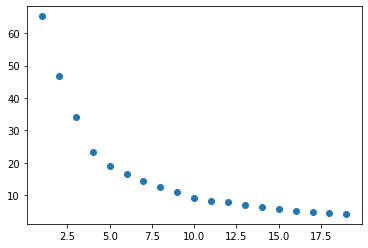

In [14]:
from matplotlib import pyplot as plt
plt.scatter(range(1, len(inertias)+1), inertias)
plt.show()

# CHOOSING MODEL FITTED WITH OPTIMAL K FOR ASSIGNING CLUSTERS

In [15]:
best_fit_index = optimal_k-1
km = fitted[best_fit_index]

terms = vectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

summaries = [[] for _ in range(optimal_k)]
titles = [[] for _ in range(optimal_k)]
for i in range(optimal_k):
    for index, cluster in enumerate(km.labels_.tolist()):
        if cluster == i:
            summaries[i].append(df['d'][index])
            titles[i].append(df['t'][index])

## USING FP-GROWTH TO GET FREQUENTLY APPEARING SETS OF WORDS FROM DATA FOR TITLES

In [16]:
# APRIORI AS ALTERNATIVE TO FPGROWTH (SLOWER)

# te = TransactionEncoder()
# from time import time
# def get_frequent_itemsets(dataset):
#     # PASSED DATASET MUST CONTAIN SPLIT WORDS APPEARING IN THE SAME ORDER AS THEIR SENTENCES
#     te_ary = te.fit_transform(dataset)
#     dataset = pd.DataFrame(te_ary, columns=te.columns_)
#     freq_itemsets = apriori(dataset, min_support=0.2, use_colnames=True)
#     freq_itemsets = freq_itemsets.sort_values('support', ascending=False)['itemsets']
#     freq_itemsets = list(filter(lambda x:len(x)>1, freq_itemsets.values.tolist()))
#     return freq_itemsets

# for index, cluster in enumerate(summaries):
#     d = list(map(lambda x: x.split(), cluster))
#     probable_titles = get_frequent_itemsets(d)
#     cluster_title = ' | '.join(list(map(lambda x: ' '.join(list(x)[::-1]), probable_titles))[:5])
    
#     print(f"CLUSTER {index+1}")
#     print(f"TITLE: {cluster_title}")
#     print('  '+'\n  '.join(titles[index]))
#     print('\n\n')

In [17]:
from mlxtend.frequent_patterns import fpgrowth
te = TransactionEncoder()
from time import time
def get_frequent_itemsets(dataset):
    # PASSED DATASET MUST CONTAIN SPLIT WORDS APPEARING IN THE SAME ORDER AS THEIR SENTENCES
    te_ary = te.fit_transform(dataset)
    dataset = pd.DataFrame(te_ary, columns=te.columns_)
    freq_itemsets = fpgrowth(dataset, min_support=0.2, use_colnames=True)
    freq_itemsets = freq_itemsets.sort_values('support', ascending=False)['itemsets']
    freq_itemsets = list(filter(lambda x:len(x)>1, freq_itemsets.values.tolist()))
    return freq_itemsets

for index, cluster in enumerate(summaries):
    d = list(map(lambda x: x.split(), cluster))
    probable_titles = get_frequent_itemsets(d)
    cluster_title = ' | '.join(list(map(lambda x: ' '.join(list(x)), probable_titles))[:5])
    
    print(f"CLUSTER {index+1}")
    print(f"TITLE: {cluster_title}")
    print('  '+'\n  '.join(titles[index]))
    print('\n\n')

CLUSTER 1
TITLE: movie coimbatore | coimbatore check | showtimes coimbatore | movie showtimes | movies coimbatore
  Coimbatore Movie Tickets Online Booking & Showtimes near you ...
  BookMyShow: Movie Tickets, Plays, Sports, Events & Cinemas nearby
  Movie Tickets, Plays, Sports, Events & Cinemas near Coimbatore ...
  Now Showing & Upcoming Movies in Coimbatore - Times of India
  Movies in Coimbatore - Online Movie Ticket Booking, Showtimes in ...
  Theatres / Cinemas in Coimbatore | Complete List of Cinemas in ...
  Movies Showtimes in Coimbatore, Show Timings of Latest Movies ...
  Carnatic Cinema: Coimbatore | Movie Showtimes & Ticket Booking ...
  Arasan Cinemas A/C 2K Dolby: Coimbatore | Movie ... - BookMyShow
  KG Cinemas: Coimbatore | Movie Showtimes & Ticket Booking Near ...
  Malayalam Movies in Coimbatore | Movie Show Timings of Now ...
  Carnatic Cinema: Coimbatore | Movie Showtimes Near You in ...
  KG Cinemas: Coimbatore | Movie Showtimes Near You in ...
  Krithika Cinemas